In [1]:
import pickle

import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd

from constants import (
    TRAIN_DATA_CSV,
    TEST_DATA_CSV,
    TEST_IMAGE_FEATURES_PATH,
    TEST_TEXT_FEATURES_PATH,
    TRAIN_IMAGE_FEATURES_PATH,
    TRAIN_TEXT_FEATURES_PATH,
    MULTIMODAL_MODEL_PATH,
    TARGET_SCALER_PATH,
)
from core.src.utils.metrics import compute_metrics
from core.src.utils.plots import plot_loss_and_metrics, print_metrics_table

In [2]:
df_train = pd.read_csv(TRAIN_DATA_CSV, dtype={"id": str})
df_test = pd.read_csv(TEST_DATA_CSV, dtype={"id": str})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open(TARGET_SCALER_PATH, "rb") as f:
    target_scaler = pickle.load(f)

In [3]:
df_train.head()

,id,price,price_std,manufacturer,model,year,km,power,engine_capacity,fuel,chassis,is_automatic,sold_by_company,description
0,019881,40000,2.975397,1.122547,0.577275,-0.616357,-1.202577,1.922580,2.303415,0.571424,1.092472,1,0,"audio si tehnologie: bluetooth,radio,port usb,..."
1,013939,22500,1.004625,1.230378,0.477085,-0.847326,-0.604734,0.495943,0.273313,0.571424,1.092472,1,1,"audio si tehnologie: bluetooth,radio,port usb,..."
2,018200,30000,1.849241,0.869288,0.488822,-0.847326,-0.939616,0.550813,0.271271,-1.750013,0.478701,1,0,bmw seria 5 g30\nkm 110000\npachet luxury line...
3,022062,7700,-0.662085,-1.087001,-1.214751,-1.309264,-0.518877,-1.424531,-0.825474,0.571424,0.478701,0,0,"audio si tehnologie: bluetooth,radio,port usb,..."
4,044090,20825,0.815994,-0.684438,-0.122026,-1.078295,-0.965912,0.313040,0.267186,0.571424,-0.805349,0,1,posibilitate leasing \n\ntva deductibil \npreț...


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17215 entries, 0 to 17214
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               17215 non-null  object 
 1   price            17215 non-null  int64  
 2   price_std        17215 non-null  float64
 3   manufacturer     17215 non-null  float64
 4   model            17215 non-null  float64
 5   year             17215 non-null  float64
 6   km               17215 non-null  float64
 7   power            17215 non-null  float64
 8   engine_capacity  17215 non-null  float64
 9   fuel             17215 non-null  float64
 10  chassis          17215 non-null  float64
 11  is_automatic     17215 non-null  int64  
 12  sold_by_company  17215 non-null  int64  
 13  description      17215 non-null  object 
dtypes: float64(9), int64(3), object(2)
memory usage: 1.8+ MB


In [5]:
STRUCTURED_COLUMNS = [
    "km",
    "power",
    "engine_capacity",
    "year",
    "manufacturer",
    "model",
    "fuel",
    "chassis",
    "sold_by_company",
    "is_automatic",
]

train_structured_data = df_train[STRUCTURED_COLUMNS].to_numpy()
test_structured_data = df_test[STRUCTURED_COLUMNS].to_numpy()

train_targets = df_train["price_std"].to_numpy()
test_targets = df_test["price_std"].to_numpy()

train_structured_data.shape, test_structured_data.shape, train_targets.shape, test_targets.shape

((17215, 10), (4304, 10), (17215,), (4304,))

In [6]:
train_image_features = np.load(TRAIN_IMAGE_FEATURES_PATH)
test_image_features = np.load(TEST_IMAGE_FEATURES_PATH)

train_text_features = np.load(TRAIN_TEXT_FEATURES_PATH)
test_text_features = np.load(TEST_TEXT_FEATURES_PATH)

len(train_image_features), len(train_text_features), len(test_image_features), len(test_text_features)

(17215, 17215, 4304, 4304)

In [7]:
class MultimodalDataset(Dataset):
    def __init__(self, image_features, text_features, structured_data, targets):
        self.image_features = image_features
        self.text_features = text_features
        self.structured_data = structured_data
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        image = torch.tensor(self.image_features[idx], dtype=torch.float32)
        text = torch.tensor(self.text_features[idx], dtype=torch.float32)

        structured = torch.tensor(self.structured_data[idx], dtype=torch.float32)
        target = torch.tensor(self.targets[idx], dtype=torch.float32)

        features = torch.cat([image, text, structured])

        return features, target


train_dataset = MultimodalDataset(train_image_features, train_text_features, train_structured_data, train_targets)
test_dataset = MultimodalDataset(test_image_features, test_text_features, test_structured_data, test_targets)

BATCH_SIZE = 1024

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

trainSteps = len(train_loader.dataset) // BATCH_SIZE
testSteps = len(test_loader.dataset) // BATCH_SIZE
history = {"train_loss": [], "test_loss": []}
metrics_history = {"train_mae": [], "test_mae": [], "train_rmse": [], "test_rmse": [], "train_r2": [], "test_r2": [], "train_mse": [], "test_mse": []}

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1546, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x


model = Net().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, min_lr=1e-9, patience=100)

In [9]:
best_val_loss = float("inf")
for epoch in range(2000):
    model.train()
    train_loss = 0.0
    all_train_predictions = []
    all_train_ground_truths = []

    for features, target in train_loader:
        features = features.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, target.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * features.size(0)

        outputs = outputs.cpu().detach().numpy()
        target = target.view(-1, 1).cpu().detach().numpy()

        unnorm_outputs = target_scaler.inverse_transform(outputs)
        unnorm_target = target_scaler.inverse_transform(target)

        all_train_predictions.extend(unnorm_outputs)
        all_train_ground_truths.extend(unnorm_target)

    train_metrics = compute_metrics(all_train_predictions, all_train_ground_truths)
    metrics_history["train_mae"].append(train_metrics["MAE"])
    metrics_history["train_mse"].append(train_metrics["MSE"])
    metrics_history["train_rmse"].append(train_metrics["RMSE"])
    metrics_history["train_r2"].append(train_metrics["R2"])

    # Validation loop (optional, but recommended)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_loss = 0.0
        all_test_predictions = []
        all_test_ground_truths = []
        for features, target in test_loader:
            features = features.to(device)
            target = target.to(device)
            outputs = model(features)
            loss = criterion(outputs, target.view(-1, 1))  # Ensure 'target' is defined for test data
            test_loss += loss.item() * features.size(0)

            outputs = outputs.cpu().detach().numpy()
            target = target.view(-1, 1).cpu().detach().numpy()

            unnorm_outputs = target_scaler.inverse_transform(outputs)
            unnorm_target = target_scaler.inverse_transform(target)

            all_test_predictions.extend(unnorm_outputs)
            all_test_ground_truths.extend(unnorm_target)

        test_metrics = compute_metrics(all_test_predictions, all_test_ground_truths)
        metrics_history["test_mae"].append(test_metrics["MAE"])
        metrics_history["test_mse"].append(test_metrics["MSE"])
        metrics_history["test_rmse"].append(test_metrics["RMSE"])
        metrics_history["test_r2"].append(test_metrics["R2"])

        train_loss /= len(train_loader.dataset)
        test_loss /= len(test_loader.dataset)

        history["test_loss"].append(test_loss)
        history["train_loss"].append(train_loss)

        scheduler.step(test_loss)
        print(scheduler.get_last_lr())

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        print("Train Metrics: ", train_metrics)
        print("Test Metrics: ", test_metrics)

        if test_loss < best_val_loss:
            best_val_loss = test_loss
            torch.save(model.state_dict(), MULTIMODAL_MODEL_PATH)
            print(f"Epoch {epoch + 1}: New best test loss: {best_val_loss}")

[5e-05]
Epoch 1, Train Loss: 0.6838, Test Loss: 0.5619
Train Metrics:  {'MAE': 6072.1357, 'MSE': 66048036.0, 'RMSE': 8126.994, 'R2': 0.1638537205182825}
Test Metrics:  {'MAE': 4989.857, 'MSE': 49353024.0, 'RMSE': 7025.171, 'R2': 0.3694179551484198}
Epoch 1: New best test loss: 0.5619354837445965
[5e-05]
Epoch 2, Train Loss: 0.4936, Test Loss: 0.3751
Train Metrics:  {'MAE': 4383.3984, 'MSE': 40499788.0, 'RMSE': 6363.9443, 'R2': 0.48728617280265973}
Test Metrics:  {'MAE': 3330.9536, 'MSE': 26507306.0, 'RMSE': 5148.5244, 'R2': 0.6613169790454292}
Epoch 2: New best test loss: 0.3751171718742768
[5e-05]
Epoch 3, Train Loss: 0.3938, Test Loss: 0.3259
Train Metrics:  {'MAE': 3496.4133, 'MSE': 25450268.0, 'RMSE': 5044.8257, 'R2': 0.6778080601412069}
Test Metrics:  {'MAE': 2893.841, 'MSE': 17735340.0, 'RMSE': 4211.3345, 'R2': 0.7733961085432449}
Epoch 3: New best test loss: 0.32589149364308356
[5e-05]
Epoch 4, Train Loss: 0.3609, Test Loss: 0.2995
Train Metrics:  {'MAE': 3204.4324, 'MSE': 20055

KeyboardInterrupt: 

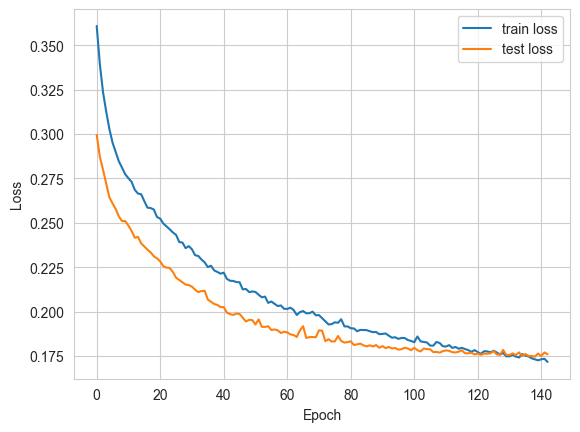

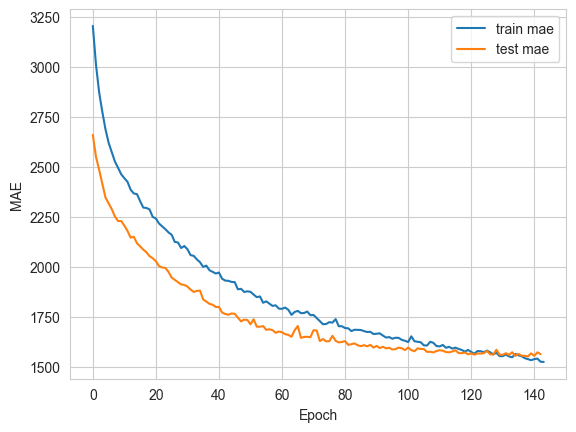

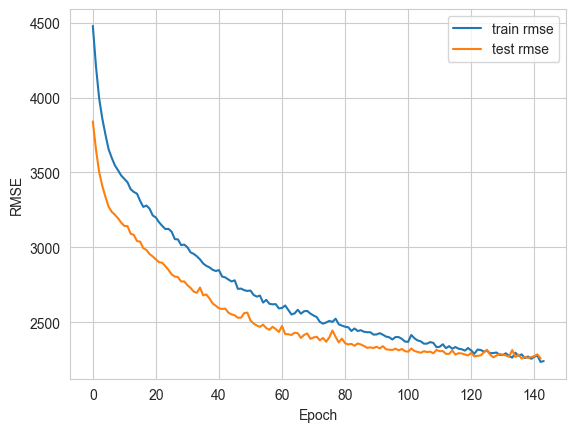

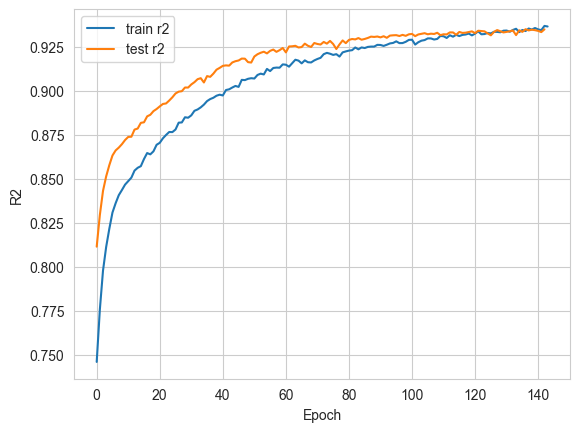

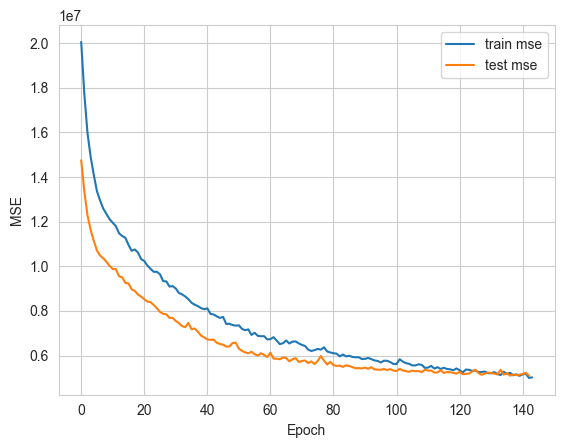

Train Metrics
+---------+---------+---------+---------+-------------+
|   Epoch |     MAE |    RMSE |      R2 |         MSE |
+=========+=========+=========+=========+=============+
|     146 | 1522.94 | 2241.11 | 0.93642 | 5.02258e+06 |
+---------+---------+---------+---------+-------------+

Test Metrics
+---------+---------+---------+--------+-------------+
|   Epoch |     MAE |    RMSE |     R2 |         MSE |
+=========+=========+=========+========+=============+
|     145 | 1561.94 | 2258.98 | 0.9348 | 5.10299e+06 |
+---------+---------+---------+--------+-------------+


In [10]:
plot_loss_and_metrics(history, metrics_history, SLICE_START=3)
print_metrics_table(metrics_history)